# Transfer Learning - Feature Extraction
Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Downlading and becoming one with data

In [1]:
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-09-25 14:01:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.217.1.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   218MB/s    in 0.7s    

2022-09-25 14:01:48 (218 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# Walk trough the data
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

There are 2 directories and 0 files in 10_food_classes_10_percent
There are 10 directories and 0 files in 10_food_classes_10_percent/train
There are 0 directories and 75 files in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 files in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 files in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 files in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 files in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 files in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 files in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 files in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 files in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 files in 10_food_classes_10_percent/train/fried_rice
There are 10 directories and 0 fi

## Preparing the data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

- Tracking experiments with the Tensorboard callback
- Model checkpoint with the ModelCheckpoint callback
- Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.


In [4]:
# Create tensorboard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving tensorboard log files to {log_dir}")
  return tensorboard_callback

## Creating models using tensorflow hub

In [5]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [6]:
# Import the dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
def create_model(model_url, num_classes=10):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A Tensorflow Hub feature extraction URL.
    num_classes (int): Number of output neuron. This should match the number of 
      classes we want to predict.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor 
    layer and Dense layer as an output layer
  """
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extractor_layer",
                                           input_shape=IMAGE_SHAPE + (3,))
  # create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model

## Creating a ResNet model from tensorflow hub

In [8]:
resnet_model = create_model(resnet_url, train_data.num_classes)

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [10]:
# Compile 
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
# Fit our model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorboard", experiment_name="resnet50V2")]
                                  )

Saving tensorboard log files to tensorboard/resnet50V2/20220925-140202
Epoch 1/5
24/24 [==============================] - 37s 853ms/step - loss: 1.8288 - accuracy: 0.3947 - val_loss: 1.1317 - val_accuracy: 0.6524
Epoch 2/5
24/24 [==============================] - 16s 670ms/step - loss: 0.8915 - accuracy: 0.7240 - val_loss: 0.8359 - val_accuracy: 0.7304
Epoch 3/5
24/24 [==============================] - 16s 677ms/step - loss: 0.6104 - accuracy: 0.8200 - val_loss: 0.7530 - val_accuracy: 0.7576
Epoch 4/5
24/24 [==============================] - 19s 818ms/step - loss: 0.4665 - accuracy: 0.8747 - val_loss: 0.7154 - val_accuracy: 0.7648
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.3728 - accuracy: 0.9027 - val_loss: 0.6771 - val_accuracy: 0.7756


- This was almost double the validation accuracy with transfer learning and that too with only 10 percent of data

In [12]:
# Plot loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Takes history model and plot loss curves for training and validation metrics

  Args:
    history: Tensorflow History Object
  
  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

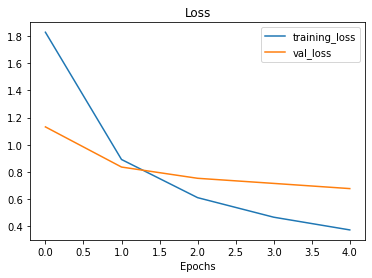

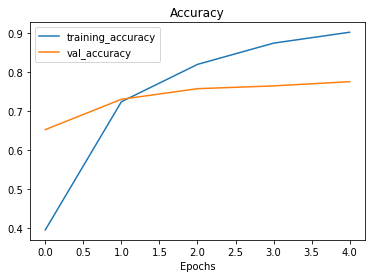

In [13]:
plot_loss_curves(resnet_history)

## Creating and testing efficient net model from tensorflow hub

In [14]:
efficientnet_model = create_model(model_url=efficientnet_url, 
                                  num_classes=train_data.num_classes)

# Compile
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])


In [15]:
# Fit model
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorboard", experiment_name="efficientnetb0")])

Saving tensorboard log files to tensorboard/efficientnetb0/20220925-140407
Epoch 1/5
24/24 [==============================] - 37s 1s/step - loss: 1.8631 - accuracy: 0.4200 - val_loss: 1.3143 - val_accuracy: 0.7376
Epoch 2/5
24/24 [==============================] - 17s 741ms/step - loss: 1.0698 - accuracy: 0.7800 - val_loss: 0.8700 - val_accuracy: 0.8208
Epoch 3/5
24/24 [==============================] - 18s 770ms/step - loss: 0.7623 - accuracy: 0.8440 - val_loss: 0.6977 - val_accuracy: 0.8436
Epoch 4/5
24/24 [==============================] - 16s 687ms/step - loss: 0.6109 - accuracy: 0.8627 - val_loss: 0.6103 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 15s 639ms/step - loss: 0.5191 - accuracy: 0.9000 - val_loss: 0.5554 - val_accuracy: 0.8632


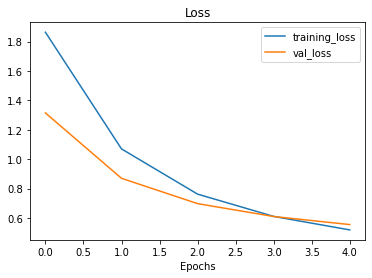

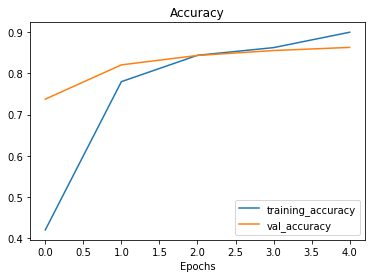

In [16]:
# Plot loss curves
plot_loss_curves(efficientnet_history)

## Different types of transfer learning
- **As is Transfer learning** - The transfer model remains the same (eg. 1000 classes remains as 1000 classes)
- **Feature Extraction transfer learning** - The tranfer model remains the same but the output layer changes (1000 classes converts to 10 output)
- **Fine Tuning Transfer Learning** - In this, some of the layers may change or may not change. 

## Comparing different types of model with Tensorboard 

In [18]:
!tensorboard dev upload --logdir ./tensorboard/ \
  --name "Compare EfficientNetB0 vs ResNet50V2" \
  --description "Comparing of the loss and accuracy of training data and validation data" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/6XcOQBdgRhK5vxND9yaw2A/

[2022-09-25T14:15:03] Started scanning logdir.
[2022-09-25T14:15:05] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.6 MB)
[2022-09-25T14:15:05] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/6XcOQBdgRhK5vxND9yaw2A/


In [19]:
!tensorboard dev list

https://tensorboard.dev/experiment/6XcOQBdgRhK5vxND9yaw2A/
	Name                 Compare EfficientNetB0 vs ResNet50V2
	Description          Comparing of the loss and accuracy of training data and validation data
	Id                   6XcOQBdgRhK5vxND9yaw2A
	Created              2022-09-25 14:15:03 (1 minute ago)
	Updated              2022-09-25 14:15:05 (1 minute ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5915943
Total: 1 experiment(s)


In [ ]:
# Deleting an experiment
# !tensorboard dev delete --experiment_id 6XcOQBdgRhK5vxND9yaw2A